In [1]:
import os
import glob
import pandas as pd

In [2]:
files = []
for file in glob.glob('../CV_outputs/*.csv'):
    files.append(file)

files

['../CV_outputs/grid_metrics_sobel_20250819_103406.csv',
 '../CV_outputs/grid_metrics_sato_20250819_103406.csv',
 '../CV_outputs/grid_metrics_canny_20250819_103344.csv',
 '../CV_outputs/grid_metrics_gabor_20250819_103402.csv']

In [3]:
# List of model names (file names without extension)
model_names = [f.split('/')[-1].split('_')[2] for f in files]

In [4]:
model_names

['sobel', 'sato', 'canny', 'gabor']

In [5]:
# Metric columns to keep
metrics = ['ae', 'mse', 'ssim', 'psnr', 'acc', 'prec', 'f1', 'rec', 'roc_auc', 'iou_nbg', 'loss']

In [6]:
# Create an empty list to collect data
rows = []

for model, file in zip(model_names, files):
    # Simulate reading CSV (use the same csv_content)
    df = pd.read_csv(file)
    
    # Take first row of metrics
    first_row = df.loc[df['loss'].idxmin(), metrics]
    
    # Add model name
    row = {'model': model}
    row.update(first_row.to_dict())
    rows.append(row)

# Create combined DataFrame
combined_df = pd.DataFrame(rows)

print(combined_df)

   model         ae       mse      ssim  psnr       acc      prec        f1  \
0  sobel  90.000000  0.035316  0.794317   inf  0.819959  0.000000  0.000000   
1   sato  89.974296  0.032570  0.798314   inf  0.825028  0.147900  0.004092   
2  canny  89.709861  0.036735  0.760972   inf  0.823873  0.446084  0.037873   
3  gabor  90.000000  0.032585  0.799960   inf  0.824887  0.000000  0.000000   

        rec   roc_auc  iou_nbg      loss  
0  0.000000 -6.133333      NaN  0.017658  
1  0.002228 -6.132297      NaN  0.016285  
2  0.021391 -6.124709      NaN  0.018368  
3  0.000000 -6.133333      NaN  0.016292  


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/utils/_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/utils/_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


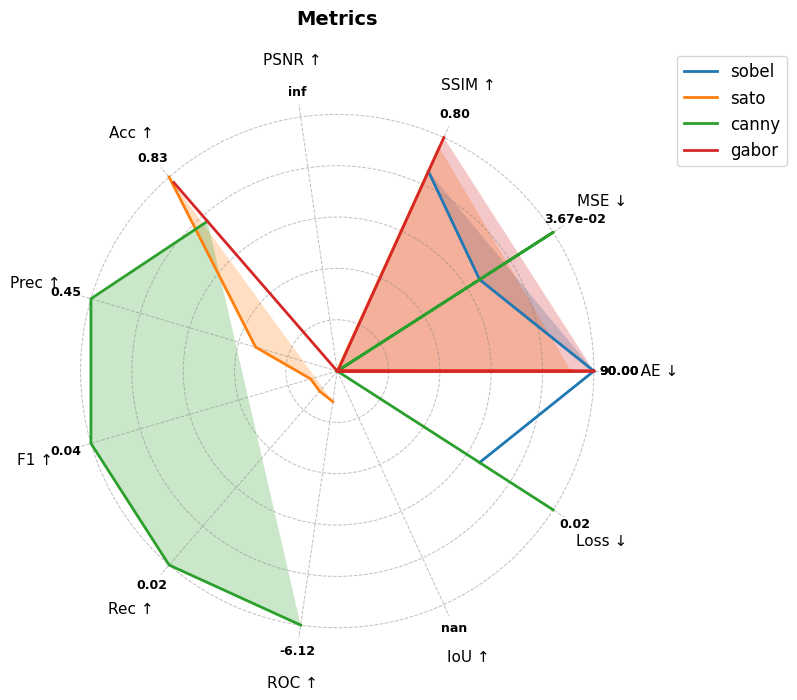

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize metrics across all models for balanced radar chart
scaler = MinMaxScaler()

data = combined_df[metrics].replace([np.inf, -np.inf], np.nan)

# Fill NaN with column median or zero
data = data.fillna(data.median())

# Extract metric values and scale them between 0 and 1
scaled_values = scaler.fit_transform(data)

# Close the radar chart loop by appending first value at end
values = np.concatenate([scaled_values, scaled_values[:, [0]]], axis=1)

# Angles for each axis
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]




fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for idx, row in enumerate(values):
    ax.plot(angles, row, linewidth=2, label=combined_df.loc[idx, 'model'])
    ax.fill(angles, row, alpha=0.25)

metric_info = {
    "mse":       ("MSE ↓", False),
    "psnr":      ("PSNR ↑", True),
    "ssim":      ("SSIM ↑", True),
    "ae":        ("   AE ↓", False),
    "acc":       ("Acc ↑", True),
    "f1":        ("F1 ↑", True),
    "prec":      ("Prec ↑", True),
    "rec":       ("Rec ↑", True),
    "roc_auc":   ("ROC ↑", True),
    "iou_nbg":   ("IoU ↑", True),
    "loss":      ("Loss ↓", False),
}

labels_with_arrows = [metric_info[m][0] for m in metrics]

max_vals = combined_df[metrics].max().values
for angle, val, m in zip(angles, np.append(max_vals, max_vals[0]), np.append(metrics, metrics[0])):
    arrow = "↑" if metric_info[m][1] else "↓"
    # Format mse with scientific notation, others with 2 decimals
    if m == "mse":
        val_str = f"{val:.2e}"
    else:
        val_str = f"{val:.2f}"
    ax.text(angle, 1.1, f"{val_str}", ha='center', va='center', fontsize=9, fontweight='bold')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels_with_arrows, fontsize=11)
ax.tick_params(pad=22)
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)
ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=12)
plt.title("Metrics", fontsize=14, fontweight='bold', pad=20)
plt.show()

In [8]:
data

,ae,mse,ssim,psnr,acc,prec,f1,rec,roc_auc,iou_nbg,loss
0,90.000000,0.035316,0.794317,NaN,0.819959,0.000000,0.000000,0.000000,-6.133333,NaN,0.017658
1,89.974296,0.032570,0.798314,NaN,0.825028,0.147900,0.004092,0.002228,-6.132297,NaN,0.016285
2,89.709861,0.036735,0.760972,NaN,0.823873,0.446084,0.037873,0.021391,-6.124709,NaN,0.018368
3,90.000000,0.032585,0.799960,NaN,0.824887,0.000000,0.000000,0.000000,-6.133333,NaN,0.016292


In [9]:
data.index = model_names
data

,ae,mse,ssim,psnr,acc,prec,f1,rec,roc_auc,iou_nbg,loss
sobel,90.000000,0.035316,0.794317,NaN,0.819959,0.000000,0.000000,0.000000,-6.133333,NaN,0.017658
sato,89.974296,0.032570,0.798314,NaN,0.825028,0.147900,0.004092,0.002228,-6.132297,NaN,0.016285
canny,89.709861,0.036735,0.760972,NaN,0.823873,0.446084,0.037873,0.021391,-6.124709,NaN,0.018368
gabor,90.000000,0.032585,0.799960,NaN,0.824887,0.000000,0.000000,0.000000,-6.133333,NaN,0.016292


In [10]:
metric_info

{'mse': ('MSE ↓', False),
 'psnr': ('PSNR ↑', True),
 'ssim': ('SSIM ↑', True),
 'ae': ('   AE ↓', False),
 'acc': ('Acc ↑', True),
 'f1': ('F1 ↑', True),
 'prec': ('Prec ↑', True),
 'rec': ('Rec ↑', True),
 'roc_auc': ('ROC ↑', True),
 'iou_nbg': ('IoU ↑', True),
 'loss': ('Loss ↓', False)}

In [11]:
data.columns= [metric_info[c][0].strip() for c in data.columns]

In [12]:
data

,AE ↓,MSE ↓,SSIM ↑,PSNR ↑,Acc ↑,Prec ↑,F1 ↑,Rec ↑,ROC ↑,IoU ↑,Loss ↓
sobel,90.000000,0.035316,0.794317,NaN,0.819959,0.000000,0.000000,0.000000,-6.133333,NaN,0.017658
sato,89.974296,0.032570,0.798314,NaN,0.825028,0.147900,0.004092,0.002228,-6.132297,NaN,0.016285
canny,89.709861,0.036735,0.760972,NaN,0.823873,0.446084,0.037873,0.021391,-6.124709,NaN,0.018368
gabor,90.000000,0.032585,0.799960,NaN,0.824887,0.000000,0.000000,0.000000,-6.133333,NaN,0.016292
